In [67]:
import cv2
import json
import glob
import os
import mmcv
import numpy as np
import matplotlib.pyplot as plt

In [14]:
game_name = '2021_02_08_OklahomaState_at_Kansas'
events_file = os.path.join('./demos/custom_5vals_colors_all_30ep_data2_50ep/', game_name, game_name + '_genius_events_annotation_processing.json')

video_path = os.path.join('/home/ubuntu/oljike/data/demo_vids/', game_name, game_name + '.mp4')
trails_path =  os.path.join('./demos/custom_5vals_colors_all_30ep_data2_50ep/', game_name, game_name + '_trails.json')

In [88]:
    
def get_result(events_file, trails_path, video_path):
    events = json.load(open(events_file))
    trails = json.load(open(trails_path))
    video = mmcv.VideoReader(video_path)

    for en, k in enumerate(trails):
        if len(trails[k]['home'])>0:
            team = 'home_team'
        else:
            team = 'away_team'

        break

    frames = []
    shot_locs = {}
    for ev in events['events']:
        if 'made' in ev['event_type'] and ev['player_jersey']=='2' and ev['team']==team:
            frames.append(ev['frame_num'])
            shot_locs['frame_num'] = ev['shot_location']


    def get_coords(js, frame):
        x, y = [], []
        bbox = {}
        trail = {}
        for en in range(frame-300, frame+100):
            if str(en) not in js: continue

            k = str(en)
            if len(js[k]['home'])>0:
                x.append(js[k]['home']['2']['trail'][0])
                y.append(js[k]['home']['2']['trail'][1])
                bbox[k] = js[k]['home']['2']['box']
                trail[k] = js[k]['home']['2']['trail']
            else:
                x.append(js[k]['away']['2']['trail'][0])
                y.append(js[k]['away']['2']['trail'][1])
                bbox[k] = js[k]['away']['2']['box']
                trail[k] = js[k]['away']['2']['trail']

        return x, y, bbox,trail

    good_tracks = 0
    xs, ys = [], []
    good_frames = []
    good_bbox = []
    good_trail = []
    for en, frame in enumerate(frames):
        x,y, bbox, trail = get_coords(trails, frame)

        if len(x)>100:
            good_tracks += 1
            good_frames.append(frame)
            xs.append(x)
            ys.append(y)
            good_bbox.append(bbox)
            good_trail.append(trail)

    print(good_tracks)


    for idx in range(good_tracks):
        if not os.path.exists('./demos/magazine/'+game_name):
            os.makedirs('./demos/magazine/'+game_name)

        out_dir = './demos/magazine/'+game_name
        out_json = os.path.join(out_dir, str(idx)+ '_results.json')
        out = cv2.VideoWriter(os.path.join(out_dir, str(idx) + '_results.mp4'), cv2.VideoWriter_fourcc(*'MP4V'), video.fps, (video.width, video.height))


        result = {}
        for i in range(good_frames[idx]-300, good_frames[idx]+100):
            frame_rgb = video.get_frame(i)
            if str(i) in good_bbox[idx]:
                curr_bbox = good_bbox[idx][str(i)]
                curr_bbox = [curr_bbox[0], curr_bbox[1], curr_bbox[0]+curr_bbox[2], curr_bbox[1]+curr_bbox[3]]
                curr_bbox = np.array(curr_bbox).astype(int)

                curr_trail = good_trail[idx][str(i)]
                
                if str(i) in shot_locs:
                    result[str(i)] = {'box': curr_bbox.tolist(), 'trail': curr_trail, 'loc': shot_locs[str(i)]}
                else:
                    result[str(i)] = {'box': curr_bbox.tolist(), 'trail': curr_trail}
                    
                cv2.rectangle(frame_rgb, (curr_bbox[0], curr_bbox[1]), (curr_bbox[2], curr_bbox[3]), color=(255,0,0), thickness=1)

            else: 
                result[str(i)] = {'box': [], 'trail': []}


            out.write(frame_rgb)   
        out.release()

        with open(out_json, 'w') as f:
            json.dump(result, f)

In [103]:
all_games = glob.glob('/home/ubuntu/oljike/data/demo_vids/*')
all_games = [x for x in all_games if os.path.isdir(x)] 

for game in all_games:
    game_name = game.split('/')[-1]
    events_file = os.path.join('./demos/custom_5vals_colors_all_30ep_data2_50ep/', game_name, game_name + '_genius_events_annotation_processing.json')

    video_path = os.path.join('/home/ubuntu/oljike/data/demo_vids/', game_name, game_name + '.mp4')
    trails_path =  os.path.join('./demos/custom_5vals_colors_all_30ep_data2_50ep/', game_name, game_name + '_trails.json')
    
    if not os.path.exists(events_file) or not os.path.exists(trails_path): continue
        
    if not os.path.exists(video_path):
        video_path = os.path.join('/home/ubuntu/oljike/data/demo_vids/', game_name, game_name + '_orig.mp4')
        
    get_result(events_file, trails_path, video_path)


8
6
4
10
3
0


In [99]:
all_games

['/home/ubuntu/oljike/data/demo_vids/2021_03_11_OklahomaState_at_WestVirginia',
 '/home/ubuntu/oljike/data/demo_vids/2021_03_12_OklahomaState_at_Baylor',
 '/home/ubuntu/oljike/data/demo_vids/2021_03_13_OklahomaState_at_Texas',
 '/home/ubuntu/oljike/data/demo_vids/2021_01_20_Colorado_at_Washington',
 '/home/ubuntu/oljike/data/demo_vids/2021_02_08_OklahomaState_at_Kansas',
 '/home/ubuntu/oljike/data/demo_vids/2020_11_28_TexasSouthern_at_OklahomaState',
 '/home/ubuntu/oljike/data/demo_vids/2021_03_01_Oklahoma_at_OklahomaState',
 '/home/ubuntu/oljike/data/demo_vids/2021_01_04_WestVirginia_at_OklahomaState',
 '/home/ubuntu/oljike/data/demo_vids/2020_12_20_OklahomaState_at_Texas',
 '/home/ubuntu/oljike/data/demo_vids/2021_02_27_OklahomaState_at_Oklahoma',
 '/home/ubuntu/oljike/data/demo_vids/2020_12_05_Oakland_at_OklahomaState']

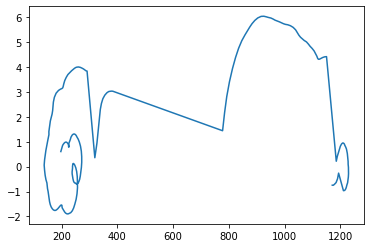

In [59]:
idx = 3
plt.plot(xs[idx],ys[idx])

### Make video